In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel, RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, skew
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

# Hide Warnings
import warnings
warnings.filterwarnings("ignore")

#feature normalization
feat_norm=True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
data = pd.read_csv('houseprice.csv')

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### |Salesprice distribution plot

In [7]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

Sales_skew = data['SalePrice'].skew()
print('Skewness = ',Sales_skew)


 mu = 180921.20 and sigma = 79415.29

Skewness =  1.8828757597682129


### Log-Salesprice Transformation distribution plot

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data["SalePrice"] = np.log1p(data["SalePrice"])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

Sales_skew = data['SalePrice'].skew()
print('Skewness = ',Sales_skew)


 mu = 12.02 and sigma = 0.40

Skewness =  0.12134661989685333


In [9]:
#check the numbers of samples and features
print("The data size before dropping Id feature is : {} ".format(data.shape))

#Save the 'Id' column
data_ID = data['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
data.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(data.shape)) 

The data size before dropping Id feature is : (1460, 81) 

The train data size after dropping Id feature is : (1460, 80) 


###Missing Data

In [10]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(50)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


Text(0.5, 1.0, 'Percent missing data by feature')

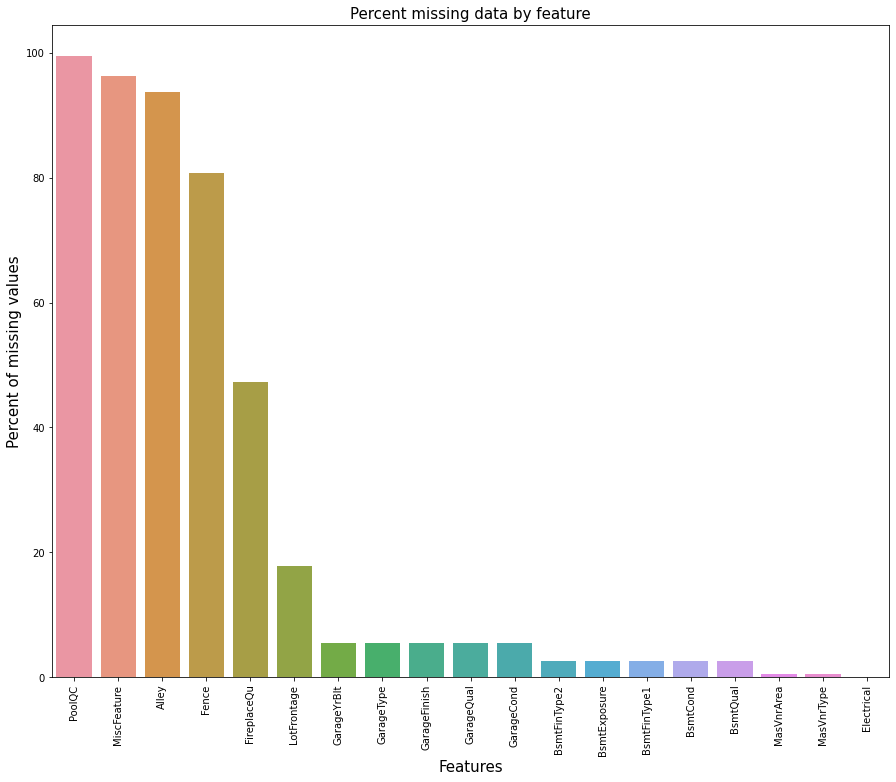

In [11]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [12]:
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'] , axis=1 , inplace=True)

### Imputing missing values

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [13]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [14]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [15]:
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.

In [16]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [17]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [18]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

Is there any remaining missing value ?

In [19]:
#Check remaining missing values if any 
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head()

,Missing Ratio


**Skewed features**

In [20]:
#Isolate numeric features
numeric_feats = data.dtypes[data.dtypes != "object"].index

#Compute skewness
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) 
#Set threshold for skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
#Identify skewed numeric features
skewed_feats = skewed_feats.index
print(skewed_feats)

#Log transform combined dataset features
data[skewed_feats] = np.log1p(data[skewed_feats])
data.head()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,0.0,5.017280,6.753438,GasA,Ex,Y,SBrkr,6.753438,6.751101,0.0,7.444833,1,0.000000,2,1,3,0.693147,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699
1,3.044522,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,0.0,5.652489,7.141245,GasA,Ex,Y,SBrkr,7.141245,0.000000,0.0,7.141245,0,0.693147,2,0,3,0.693147,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016
2,4.110874,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,0.0,6.075346,6.825460,GasA,Ex,Y,SBrkr,6.825460,6.765039,0.0,7.488294,1,0.000000,2,1,3,0.693147,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317171
3,4.262680,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,0.0,6.293419,6.629363,GasA,Gd,Y,SBrkr,6.869014,6.629363,0.0,7.448916,1,0.000000,1,0,3,0.693147,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849405
4,4.110874,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,0.0,6.196444,7.044033,GasA,Ex,Y,SBrkr,7.044033,6.960348,0.0,7.695758,1,0.000000,2,1,4,0.693147,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429220


**Correlation**

In [21]:
data.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.406131,-0.378062,0.078346,-0.039820,-0.002896,0.039769,0.014375,-0.092035,-0.085838,-0.108359,-0.110166,-0.319266,0.533799,0.081066,0.197078,-0.040138,0.002561,0.181546,0.287581,0.065690,0.252674,0.156727,0.005168,-0.059950,-0.010493,-0.078472,0.040092,0.028998,0.013820,-0.035954,-0.019569,0.025239,-0.028008,0.010286,-0.027520,-0.020279
LotFrontage,-0.406131,1.000000,0.683399,0.209408,-0.022015,0.090389,0.062012,0.137244,0.087867,0.051091,0.101045,0.128611,0.440796,-0.058605,-0.010250,0.335924,0.085929,0.014851,0.167560,0.022890,0.273490,0.019110,0.330280,0.236601,0.118997,0.282675,0.331254,0.059835,0.127389,-0.021198,0.059332,0.047759,0.113985,0.035495,0.017592,0.001920,0.361816
LotArea,-0.378062,0.683399,1.000000,0.178220,-0.006308,0.021943,0.027672,0.069262,0.096966,0.084312,0.047510,0.125525,0.467442,-0.012775,-0.010681,0.385457,0.138279,0.047896,0.179193,0.038728,0.279173,0.002947,0.360131,0.327765,0.139040,0.272010,0.322048,0.122915,0.137754,-0.015186,0.055375,0.087518,0.097257,0.080298,0.010518,-0.027164,0.399923
OverallQual,0.078346,0.209408,0.178220,1.000000,-0.091932,0.572323,0.550684,0.409317,0.054199,-0.101469,0.268446,0.344369,0.456066,0.198064,-0.029924,0.614207,0.111098,-0.041567,0.550600,0.273458,0.101676,-0.181780,0.427452,0.396765,0.288998,0.600671,0.562022,0.283256,0.445101,-0.158648,0.027546,0.049983,0.072651,-0.085131,0.070815,-0.027347,0.817185
OverallCond,-0.039820,-0.022015,-0.006308,-0.091932,1.000000,-0.375983,0.073741,-0.154307,0.045200,0.077992,-0.030805,0.008810,-0.136791,0.055934,0.028580,-0.101960,-0.054942,0.121170,-0.194149,-0.060769,0.012980,-0.084994,-0.057583,-0.023820,-0.006515,-0.185758,-0.151521,-0.039085,-0.100783,0.092471,0.038835,0.061548,-0.008085,0.079251,-0.003511,0.043950,-0.036868
YearBuilt,-0.002896,0.090389,0.021943,0.572323,-0.375983,1.000000,0.592855,0.407628,0.151209,-0.068793,0.090576,0.199087,0.277496,-0.077171,-0.182266,0.235500,0.187599,-0.040385,0.468271,0.242656,-0.070651,-0.171485,0.095589,0.147716,0.272029,0.537850,0.478954,0.307474,0.389065,-0.446694,0.028977,-0.059629,0.005805,-0.077819,0.012398,-0.013618,0.586570
YearRemodAdd,0.039769,0.062012,0.027672,0.550684,0.073741,0.592855,1.000000,0.220650,0.012105,-0.102425,0.167086,0.205200,0.233735,0.073894,-0.057486,0.311456,0.119470,-0.013277,0.439046,0.183331,-0.040581,-0.148805,0.191740,0.112581,0.146357,0.420622,0.371600,0.285773,0.382743,-0.226996,0.052398,-0.039983,0.009025,-0.074574,0.021490,0.035743,0.565608
MasVnrArea,0.014375,0.137244,0.069262,0.409317,-0.154307,0.407628,0.220650,1.000000,0.185368,-0.061345,0.092302,0.184837,0.327280,-0.014596,-0.107796,0.302385,0.113200,0.040039,0.276383,0.149928,0.090383,-0.061518,0.233253,0.224263,0.176266,0.387151,0.368396,0.163106,0.207023,-0.185680,0.047540,0.038658,0.005662,-0.053511,0.018070,-0.002286,0.413318
BsmtFinSF1,-0.092035,0.087867,0.096966,0.054199,0.045200,0.151209,0.012105,0.185368,1.000000,0.185051,-0.265488,0.290132,0.198734,-0.205426,-0.063563,-0.014440,0.591148,0.109654,-0.085258,-0.005373,-0.094666,-0.134300,-0.091730,0.146194,0.105464,0.070302,0.117933,0.082144,0.015075,-0.127733,0.051775,0.073392,0.042147,0.018808,-0.027153,0.033702,0.208099
BsmtFinSF2,-0.085838,0.051091,0.084312,-0.101469,0.077992,-0.068793,-0.102425,-0.061345,0.185051,1.000000,-0.272666,0.074690,0.070848,-0.112673,0.006314,-0.042450,0.150317,0.117454,-0.098518,-0.048083,0.007036,-0.036441,-0.045136,0.039273,0.041793,-0.053164,-0.018257,0.059134,-0.077644,0.038587,-0.022537,0.063879,0.068055,0.027978,-0.022430,0.029337,-0.030361


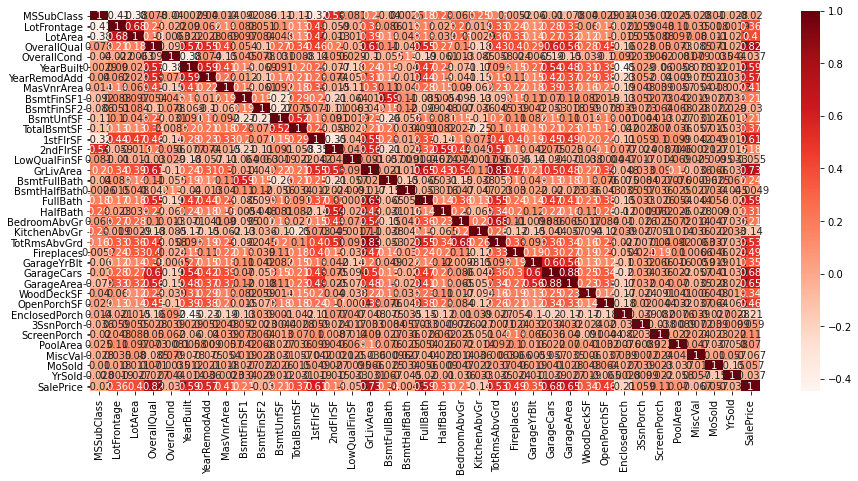

MSSubClass      0.020279
OverallCond     0.036868
BsmtFinSF2      0.030361
LowQualFinSF    0.054513
BsmtHalfBath    0.004890
3SsnPorch       0.058827
PoolArea        0.069949
MiscVal         0.067054
MoSold          0.057330
YrSold          0.037263
Name: SalePrice, dtype: float64

In [22]:
data["SalePrice"] = data.SalePrice
X = data.drop("SalePrice",1)
y = data["SalePrice"]
data.head()
plt.figure(figsize=(15,7))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor["SalePrice"]) #absolute value
#High Correlations
relevant_features = cor_target[cor_target<0.1]
relevant_features

In [23]:
newdata = data.drop(['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], axis=1)

In [24]:
newdata.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice
0,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,5.017280,6.753438,GasA,Ex,Y,SBrkr,6.753438,6.751101,7.444833,1,2,1,3,0.693147,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0.000000,4.127134,0.000000,0.0,WD,Normal,12.247699
1,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,5.652489,7.141245,GasA,Ex,Y,SBrkr,7.141245,0.000000,7.141245,0,2,0,3,0.693147,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,5.700444,0.000000,0.000000,0.0,WD,Normal,12.109016
2,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,6.075346,6.825460,GasA,Ex,Y,SBrkr,6.825460,6.765039,7.488294,1,2,1,3,0.693147,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0.000000,3.761200,0.000000,0.0,WD,Normal,12.317171
3,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,6.293419,6.629363,GasA,Gd,Y,SBrkr,6.869014,6.629363,7.448916,1,1,0,3,0.693147,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0.000000,3.583519,5.609472,0.0,WD,Abnorml,11.849405
4,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,6.196444,7.044033,GasA,Ex,Y,SBrkr,7.044033,6.960348,7.695758,1,2,1,4,0.693147,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,5.262690,4.442651,0.000000,0.0,WD,Normal,12.429220


In [25]:
data=pd.DataFrame(newdata)

## Adding new features

In [26]:
data["TotalHouse"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]   
data["TotalArea"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"] + data["GarageArea"]

In [27]:
data.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea'], axis=1, inplace=True)

In [28]:
data.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice,TotalHouse,TotalArea
0,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,Unf,5.017280,GasA,Ex,Y,SBrkr,7.444833,1,2,1,3,0.693147,Gd,8,Typ,0,Attchd,2003.0,RFn,2,TA,TA,Y,0.000000,4.127134,0.000000,0.0,WD,Normal,12.247699,20.257977,568.257977
1,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,Unf,5.652489,GasA,Ex,Y,SBrkr,7.141245,0,2,0,3,0.693147,TA,6,Typ,1,Attchd,1976.0,RFn,2,TA,TA,Y,5.700444,0.000000,0.000000,0.0,WD,Normal,12.109016,14.282490,474.282490
2,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,Unf,6.075346,GasA,Ex,Y,SBrkr,7.488294,1,2,1,3,0.693147,Gd,6,Typ,1,Attchd,2001.0,RFn,2,TA,TA,Y,0.000000,3.761200,0.000000,0.0,WD,Normal,12.317171,20.415959,628.415959
3,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,Unf,6.293419,GasA,Gd,Y,SBrkr,7.448916,1,1,0,3,0.693147,Gd,7,Typ,1,Detchd,1998.0,Unf,3,TA,TA,Y,0.000000,3.583519,5.609472,0.0,WD,Abnorml,11.849405,20.127741,662.127741
4,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,Unf,6.196444,GasA,Ex,Y,SBrkr,7.695758,1,2,1,4,0.693147,Gd,9,Typ,1,Attchd,2000.0,RFn,3,TA,TA,Y,5.262690,4.442651,0.000000,0.0,WD,Normal,12.429220,21.048414,857.048414


**Transforming some numerical variables that are really categorical**

In [29]:
#MSSubClass=The building class
#data['MSSubClass'] = data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
#data['OverallCond'] = data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
#data['YrSold'] = data['YrSold'].astype(str)
#data['MoSold'] = data['MoSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set**

In [30]:
from sklearn.preprocessing import LabelEncoder
cols = ('BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

# shape        
print('Shape all_data: {}'.format(data.shape))

Shape all_data: (1460, 63)


**Getting dummy categorical features**

In [31]:
data = pd.get_dummies(data)
print(data.shape)

(1460, 202)


# Modelling

In [32]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

In [33]:
#Feature Scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, index = X.index, columns = X.columns)
X = X_scaled_df

## Test-Train-Split

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=365)

## 1. Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression

**Ordinary Least Squares to check p-values**

In [36]:
x1 = sm.add_constant(X)
results = sm.OLS(y,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     98.47
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        06:25:32   Log-Likelihood:                 1238.6
No. Observations:                1460   AIC:                            -2115.
Df Residuals:                    1279   BIC:                            -1158.
Df Model:                         180                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.2416      0.020    402.379      0.000       8.201       8.282
LotFrontage               0.0020      0.005      0.425      0.671      -0.007       0.012
LotArea                   0.0396      0.005      7.629      0.000       0.029       0.050
Street                    0.0870      0.054      1.601      0.110      -0.020       0.193
LotShape                  0.0072      0.008      0.934      0.350      -0.008       0.022
LandSlope                 0.0089      0.016      0.569      0.570      -0.022       0.040
OverallQual               0.1011      0.009     10.823      0.000       0.083       0.119
YearBuilt                 0.0437      0.016      2.768      0.006       0.013       0.075
YearRemodAdd              0.0579      0.009      6.775      0.000       0.041       0.075
MasVnrArea                0.0165      0.029      0.569      0.569      -0.040       0.074
ExterQual                -0.0092      0.007     -1.233      0.218      -0.024       0.005
ExterCond                 0.0028      0.005      0.602      0.547      -0.006       0.012
BsmtQual                 -0.0204      0.008     -2.558      0.011      -0.036      -0.005
BsmtCond                  0.0073      0.004      2.041      0.041       0.000       0.014
BsmtExposure             -0.0092      0.003     -2.672      0.008      -0.016      -0.002
BsmtFinType1             -0.0021      0.012     -0.172      0.863      -0.026       0.022
BsmtFinSF1                0.0694      0.014      4.953      0.000       0.042       0.097
BsmtFinType2             -0.0010      0.003     -0.362      0.718      -0.007       0.005
BsmtUnfSF                -0.0033      0.003     -1.048      0.295      -0.010       0.003
HeatingQC                -0.0391      0.009     -4.142      0.000      -0.058      -0.021
CentralAir                0.0793      0.018      4.400      0.000       0.044       0.115
GrLivArea                 0.1888      0.013     14.539      0.000       0.163       0.214
BsmtFullBath              0.0276      0.008      3.405      0.001       0.012       0.043
FullBath                  0.0209      0.010      2.043      0.041       0.001       0.041
HalfBath                  0.0089      0.010      0.894      0.372      -0.011       0.028
BedroomAbvGr             -0.0054      0.006     -0.846      0.398      -0.018       0.007
KitchenAbvGr             -0.1380      0.065     -2.108      0.035      -0.266      -0.010
KitchenQual              -0.0210      0.005     -3.915      0.000      -0.032      -0.010
TotRmsAbvGrd              0.0120      0.009      1.393      0.164      -0.005       0.029
Functional                0.0276      0.003      7.915      0.000       0.021       0.034
Fireplaces                0.0174      0.006      2.736      0.006       0.005       0.030
GarageYrBlt            

In [37]:
# Multiple Linear Regression
reg = LinearRegression()

In [38]:
# Sequential Forward Selection(sfs)
sfs_lin = SFS(reg, k_features=28, forward=True, floating=False, scoring = 'r2', cv = 10)

In [39]:
sfs_lin.fit(X, y)
sfs_lin.k_feature_names_

('LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'HeatingQC',
 'CentralAir',
 'GrLivArea',
 'BsmtFullBath',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'WoodDeckSF',
 'ScreenPorch',
 'MSZoning_C (all)',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'HouseStyle_1.5Fin',
 'HouseStyle_2Story',
 'Exterior1st_BrkFace',
 'SaleType_WD',
 'SaleCondition_Abnorml')

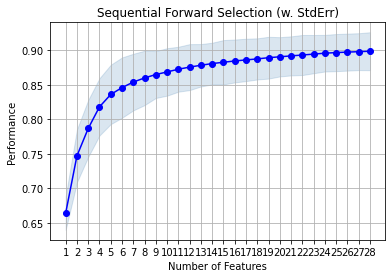

In [40]:
fig1 = plot_sfs(sfs_lin.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [42]:
feature_cols = ['LotArea','OverallQual','YearBuilt','YearRemodAdd','BsmtFinSF1','HeatingQC','CentralAir','GrLivArea','BsmtFullBath','KitchenAbvGr','KitchenQual','Functional','GarageCars','WoodDeckSF','ScreenPorch','MSZoning_C (all)','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_Somerst','Neighborhood_StoneBr','Condition1_Norm','HouseStyle_1.5Fin','HouseStyle_2Story','Exterior1st_BrkFace','SaleType_WD','SaleCondition_Abnorml']
X1 = data[feature_cols]
X1.shape

(1460, 28)

In [43]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y,test_size=0.3, random_state=20)

In [44]:
LR_model=LinearRegression()
LR_model.fit(X1_train,y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
reg_score_train = LR_model.score(X1_train, y1_train)
reg_score_test = LR_model.score(X1_test, y1_test)
print('Accuracy of train data:',reg_score_train)
print('Accuracy of test data:' ,reg_score_test)

Accuracy of train data: 0.9076830575276312
Accuracy of test data: 0.8958995744222505


## 2.Lasso Regression

In [46]:
# Lasso Regression
lasso = Lasso(alpha=0.0001) 
lasso.fit(X1_train, y1_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
lasso_score_train = lasso.score(X1_train, y1_train)
lasso_score_test = lasso.score(X1_test, y1_test)
print('Accuracy of train data:',lasso_score_train)
print('Accuracy of test data:' ,lasso_score_test)

Accuracy of train data: 0.9076312140541365
Accuracy of test data: 0.8958253098818015


### Hyperparameters for lasso

**Ramdomized Search**

In [48]:
params={'alpha':[1e-5,500], 'fit_intercept':[1e-5, 50], 'max_iter':[100,500], 'normalize':[True,False]}

In [49]:
lasso_rs = RandomizedSearchCV(lasso,param_distributions=params,scoring='r2',cv=10)
lasso_rs.fit(X1_train, y1_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Lasso(alpha=0.0001, copy_X=True,
                                   fit_intercept=True, max_iter=1000,
                                   normalize=False, positive=False,
                                   precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001,
                                   warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': [1e-05, 500],
                                        'fit_intercept': [1e-05, 50],
                                        'max_iter': [100, 500],
                                        'normalize': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='r2', verbose=0)

In [50]:
lasso_rs_score_train = lasso_rs.score(X1_train, y1_train)
lasso_rs_score_test = lasso_rs.score(X1_test, y1_test)
print('best parameters: ', lasso_rs.best_params_)
print('Accuracy of train data:',lasso_rs_score_train)
print('Accuracy of test data:' ,lasso_rs_score_test)

best parameters:  {'normalize': False, 'max_iter': 100, 'fit_intercept': 50, 'alpha': 1e-05}
Accuracy of train data: 0.9076825425142229
Accuracy of test data: 0.8958982576269945


## 3. Ridge Regression

In [51]:
ridge=Ridge()
ridge.fit(X1_train, y1_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [52]:
ridge_score_train = ridge.score(X1_train, y1_train)
ridge_score_test = ridge.score(X1_test, y1_test)
print('Accuracy of train data:',ridge_score_train)
print('Accuracy of test data:' ,ridge_score_test)

Accuracy of train data: 0.9074407097449114
Accuracy of test data: 0.896072023734965


### Hyperparameters for Ridge

**Randomized Search**

In [53]:
params={'alpha':[1e-5,500], 'fit_intercept':[1e-5, 50], 'max_iter':[50,500], 'normalize':[True,False]}

In [54]:
ridge_rs = RandomizedSearchCV(ridge,param_distributions=params, cv=10)
ridge_rs.fit(X1_train, y1_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': [1e-05, 500],
                                        'fit_intercept': [1e-05, 50],
                                        'max_iter': [50, 500],
                                        'normalize': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [55]:
ridge_rs_score_train = ridge_rs.score(X1_train, y1_train)
ridge_rs_score_test = ridge_rs.score(X1_test, y1_test)
print('best parameters: ', ridge_rs.best_params_)
print('Accuracy of train data:',ridge_rs_score_train)
print('Accuracy of test data:' ,ridge_rs_score_test)

best parameters:  {'normalize': True, 'max_iter': 50, 'fit_intercept': 50, 'alpha': 1e-05}
Accuracy of train data: 0.907683057485634
Accuracy of test data: 0.895899752065644


## 4. Decision tree regression

In [56]:
from sklearn.tree import DecisionTreeRegressor

In [57]:
# Decision Tree Regression
dectreereg = DecisionTreeRegressor()

In [58]:
# Sequential Forward Selection(sfs)
sfs_dectreereg = SFS(dectreereg, k_features=28, forward=True, floating=False, scoring = 'r2', cv = 10)

In [59]:
sfs_dectreereg.fit(X, y)
sfs_dectreereg.k_feature_names_

('OverallQual',
 'CentralAir',
 'TotRmsAbvGrd',
 'GarageCars',
 'MSZoning_C (all)',
 'MSZoning_RL',
 'Neighborhood_Blmngtn',
 'Neighborhood_Gilbert',
 'Neighborhood_NWAmes',
 'Neighborhood_SWISU',
 'Neighborhood_Somerst',
 'Neighborhood_Veenker',
 'Condition1_RRNe',
 'Condition2_Feedr',
 'Condition2_PosA',
 'HouseStyle_1.5Unf',
 'RoofMatl_Roll',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_BrkComm',
 'Exterior2nd_Stone',
 'Foundation_Slab',
 'Heating_Floor',
 'Heating_GasW',
 'SaleType_COD',
 'SaleType_Con',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca')

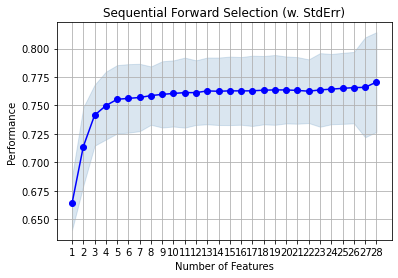

In [60]:
fig2 = plot_sfs(sfs_dectreereg.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [61]:
feature_cols_dectreereg = ['OverallQual','CentralAir','TotRmsAbvGrd','GarageCars','MSZoning_C (all)','MSZoning_FV','MSZoning_RL','Utilities_AllPub','LotConfig_FR3','Neighborhood_Gilbert','Neighborhood_NPkVill','Neighborhood_SWISU','Neighborhood_Veenker','Condition2_RRAe','BldgType_Duplex','HouseStyle_1.5Unf','HouseStyle_SLvl','RoofMatl_Metal','RoofMatl_WdShngl','Exterior1st_AsphShn','Exterior2nd_Brk Cmn','Exterior2nd_Wd Shng','Foundation_Wood','Heating_GasW','Electrical_Mix','GarageType_BuiltIn','SaleType_ConLw','SaleType_Oth']
X2 = data[feature_cols_dectreereg]
X2.shape

(1460, 28)

In [62]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y,test_size=0.3, random_state=100)

In [63]:
dectreereg.fit(X2_train, y2_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [64]:
dectreereg_score_train = dectreereg.score(X2_train, y2_train)
dectreereg_score_test = dectreereg.score(X2_test, y2_test)
print('Accuracy of train data:',dectreereg_score_train)
print('Accuracy of test data:' ,dectreereg_score_test)

Accuracy of train data: 0.911009338228598
Accuracy of test data: 0.7221239426118569


###  Decision tree using hyperparametric tuning

**Randomized Search**

In [65]:
params = {'criterion':['mse','mae'], 'max_depth':[2,20]
        , 'min_samples_split':[1,20], 'min_samples_leaf':[1,50]
        , 'min_impurity_decrease':[0.0,0.9]}

In [66]:
dectreereg_rs = RandomizedSearchCV(dectreereg,param_distributions=params, cv=10)
dectreereg_rs.fit(X2_train, y2_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='

In [67]:
dectreereg_rs_score_train = dectreereg_rs.score(X2_train, y2_train)
dectreereg_rs_score_test = dectreereg_rs.score(X2_test, y2_test)
print('best parameters: ', dectreereg_rs.best_params_)
print('Accuracy of train data:',dectreereg_rs_score_train)
print('Accuracy of test data:' ,dectreereg_rs_score_test)

best parameters:  {'min_samples_split': 20, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_depth': 20, 'criterion': 'mae'}
Accuracy of train data: 0.8444197177545779
Accuracy of test data: 0.7648782714636295


## 5. Gradient Boosting

In [68]:
from sklearn.ensemble import GradientBoostingRegressor

In [69]:
# Gradient Boosting Regression
gbr = GradientBoostingRegressor( )
sfs_gbr = SFS(gbr, k_features=18, forward=True, floating=False, scoring = 'r2', cv = 10)

In [70]:
sfs_gbr.fit(X, y)
sfs_gbr.k_feature_names_

('LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinType1',
 'BsmtFinSF1',
 'GrLivArea',
 'Fireplaces',
 'GarageCars',
 'TotalHouse',
 'MSZoning_C (all)',
 'Neighborhood_Crawfor',
 'Neighborhood_NAmes',
 'Neighborhood_Veenker',
 'Condition1_Norm',
 'Exterior1st_VinylSd',
 'Exterior2nd_MetalSd',
 'SaleCondition_Partial')

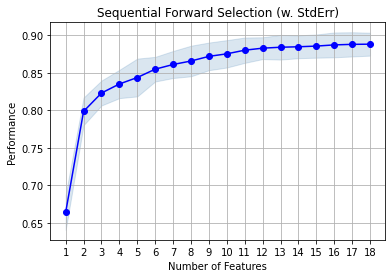

In [71]:
fig2 = plot_sfs(sfs_gbr.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [72]:
feat ure_cols_gbr = ['LotArea','OverallQual','YearBuilt','YearRemodAdd','BsmtExposure','BsmtFinType1','BsmtFinSF1','CentralAir','GrLivArea','Fireplaces','GarageQual','TotalHouse','MSZoning_C (all)','MSZoning_RL','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_IDOTRR','Exterior2nd_HdBoard']
X3 = data[feature_cols_gbr]
X3.shape

(1460, 18)

In [73]:
 X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y,test_size=0.2, random_state=50)

In [74]:
gbr.fit(X3_train, y3_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [75]:
gbr_score_train = gbr.score(X3_train, y3_train)
gbr_score_test = gbr.score(X3_test, y3_test)
print('Accuracy of train data:',gbr_score_train)
print('Accuracy of test data:' ,gbr_score_test)

Accuracy of train data: 0.9429065411560092
Accuracy of test data: 0.8891815146428456


### Gradient Boosting using hyperparameteric **tuning**

**Randomizer Search**

In [76]:
params ={ 'criterion':['mse','friedman_mse'], 'max_depth':[2,50], 'min_samples_leaf':[1,8]
        , 'min_samples_split':[2,50] , 'n_estimators':[50,250]
        , 'random_state':[50,100]}

In [77]:
gbr_rs = RandomizedSearchCV(gbr,param_distributions=params, cv=10)
gbr_rs.fit(X3_train, y3_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [78]:
gbr_rs_score_train = gbr_rs.score(X3_train, y3_train)
gbr_rs_score_test = gbr_rs.score(X3_test, y3_test)
print('best parameters: ', gbr_rs.best_params_)
print('Accuracy of train data:',gbr_rs_score_train)
print('Accuracy of test data:' ,gbr_rs_score_test)

best parameters:  {'random_state': 100, 'n_estimators': 250, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_depth': 2, 'criterion': 'friedman_mse'}
Accuracy of train data: 0.9333279202119803
Accuracy of test data: 0.8886609192074966


# Ensemble Methods

## 6. Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
# Random Forest Regression
rf = RandomForestRegressor( )

In [81]:
feature_cols_rf = ['LotArea','OverallQual','YearBuilt','YearRemodAdd','BsmtExposure','BsmtFinType1','BsmtFinSF1','CentralAir','GrLivArea','Fireplaces','GarageQual','TotalHouse','MSZoning_C (all)','MSZoning_RL','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_IDOTRR','Exterior2nd_HdBoard']
X4 = data[feature_cols_rf]
X4.shape

(1460, 18)

In [82]:
 X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y,test_size=0.2, random_state=50)

In [83]:
rf.fit(X4_train, y4_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [84]:
ranforestreg_score_train = rf.score(X4_train, y4_train)
ranforestreg_score_test = rf.score(X4_test,y4_test)
print('Accuracy of train data:',ranforestreg_score_train)
print('Accuracy of test data:' ,ranforestreg_score_test)

Accuracy of train data: 0.9812751885403125
Accuracy of test data: 0.8848961722405279


### Random Forest using hyperparametric tining

**Randomized Search**

In [85]:
params = {'criterion':['mse','rmse'], 'min_impurity_decrease':[0.0,0.8]
        , 'min_samples_leaf':[1,9], 'min_samples_split':[2,20]
        , 'n_estimators':[10,300], 'random_state':[10,500]}

In [86]:
ranforestreg_rs = RandomizedSearchCV(rf,param_distributions=params,cv=10)
ranforestreg_rs.fit(X4_train, y4_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [87]:
ranforestreg_rs_score_train = ranforestreg_rs.score(X4_train, y4_train)
ranforestreg_rs_score_test = ranforestreg_rs.score(X4_test, y4_test)
print('best parameters: ', ranforestreg_rs.best_params_)
print('Accuracy of train data:',ranforestreg_rs_score_train)
print('Accuracy of test data:' ,ranforestreg_rs_score_test)

best parameters:  {'random_state': 10, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.0, 'criterion': 'mse'}
Accuracy of train data: 0.8953925769220347
Accuracy of test data: 0.8681051758581966


## 7. Extra Trees

In [88]:
from sklearn.ensemble import ExtraTreesRegressor

In [89]:
# Extra Trees Regression
etr = ExtraTreesRegressor( )
etr.fit(X, y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [90]:
feature_cols_etr = ['LotArea','OverallQual','YearBuilt','YearRemodAdd','BsmtExposure','BsmtFinType1','BsmtFinSF1','CentralAir','GrLivArea','Fireplaces','GarageQual','TotalHouse','MSZoning_C (all)','MSZoning_RL','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_IDOTRR','Exterior2nd_HdBoard']
X5 = data[feature_cols_etr]
X5.shape

(1460, 18)

In [91]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y,test_size=0.2, random_state=30)

In [92]:
etr.fit(X5_train, y5_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [93]:
etr_score_train = etr.score(X5_train, y5_train)
etr_score_test = etr.score(X5_test,y5_test)
print('Accuracy of train data:',etr_score_train)
print('Accuracy of test data:' ,etr_score_test)

Accuracy of train data: 0.999985433296018
Accuracy of test data: 0.8614374786488712


### Extra Tree using Hyperparametric Tuning

**Randomized Search**

In [128]:
params = {'criterion':['mse','mae']
        , 'min_samples_leaf':[1,9], 'min_samples_split':[8,18]
        , 'n_estimators':[100,500]
        ,'random_state':[100,300]}

In [129]:
etr_rs = RandomizedSearchCV(etr,param_distributions=params,cv=10)
etr_rs.fit(X5_train, y5_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                                 criterion='mse',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                        

In [130]:
etr_rs_score_train = etr_rs.score(X5_train, y5_train)
etr_rs_score_test = etr_rs.score(X5_test, y5_test)
print('best parameters: ', etr_rs.best_params_)
print('Accuracy of train data:',etr_rs_score_train)
print('Accuracy of test data:' ,etr_rs_score_test)

best parameters:  {'random_state': 300, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'mae'}
Accuracy of train data: 0.9766808617830741
Accuracy of test data: 0.8631845531070761


## 8. Extreme Gradient Boosting

In [97]:
from xgboost.sklearn import XGBRegressor

In [98]:
# Extra Trees Regression
xgb = XGBRegressor( )
xgb.fit(X, y)

[08:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [99]:
feature_cols_xgb = ['LotArea','OverallQual','YearBuilt','YearRemodAdd','BsmtExposure','BsmtFinType1','BsmtFinSF1','CentralAir','GrLivArea','Fireplaces','GarageQual','TotalHouse','MSZoning_C (all)','MSZoning_RL','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_IDOTRR','Exterior2nd_HdBoard']
X6 = data[feature_cols_xgb]
X6.shape

(1460, 18)

In [100]:
X6_train, X6_test, y6_train, y6_test = train_test_split(X6,y,test_size=0.2, random_state=20)

In [101]:
xgb.fit(X6_train, y6_train)

[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [102]:
xgb_score_train = xgb.score(X6_train, y6_train)
xgb_score_test = xgb.score(X6_test,y6_test)
print('Accuracy of train data:',xgb_score_train)
print('Accuracy of test data:' ,xgb_score_test)

Accuracy of train data: 0.9347568502987192
Accuracy of test data: 0.8767960995027572


### XGB using Hypreparametric Tuning

**Randomized Search**

In [103]:
params = {'base_score':[0.2,0.6], 'max_delta_step':[0,6]
        , 'max_depth':[2,12], 'n_estimators':[50,400],'random_state':[50,300]}

In [104]:
xgb_rs = RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',cv=10)
xgb_rs.fit(X6_train, y6_train)

[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                 

In [105]:
xgb_rs_score_train = xgb_rs.score(X6_train, y6_train)
xgb_rs_score_test = xgb_rs.score(X6_test, y6_test)
print('best parameters: ', xgb_rs.best_params_)
print('Accuracy of train data:',xgb_rs_score_train)
print('Accuracy of test data:' ,xgb_rs_score_test)


best parameters:  {'random_state': 50, 'n_estimators': 400, 'max_depth': 2, 'max_delta_step': 6, 'base_score': 0.2}
Accuracy of train data: 0.9417699724885926
Accuracy of test data: 0.8984919746576374


# Summary

In [131]:
summary=pd.DataFrame()
summary['Models'] = ['Multiple Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree',
                     'Random Forest', 'Extra tree Regression', 'Gradient Boosting Regression', 'XGBoost']
summary['Train_Score'] = reg_score_train,ridge_score_train,lasso_score_train,dectreereg_score_train,ranforestreg_score_train,etr_score_train,gbr_score_train,xgb_score_train
summary['Test_Score'] = reg_score_test,ridge_score_test,lasso_score_test,dectreereg_score_test,ranforestreg_score_test,etr_score_test,gbr_score_test,xgb_score_test

summary['Tuned_Train_Score_rs'] = '-',lasso_rs_score_train,ridge_rs_score_train,dectreereg_rs_score_train,ranforestreg_rs_score_train,etr_rs_score_train,gbr_rs_score_train,xgb_rs_score_train
summary['Tuned_Test_Score_rs'] = '-',lasso_rs_score_test,ridge_rs_score_test,dectreereg_rs_score_test,ranforestreg_rs_score_test,etr_rs_score_test,gbr_rs_score_test,xgb_rs_score_test

summary

,Models,Train_Score,Test_Score,Tuned_Train_Score_rs,Tuned_Test_Score_rs
0,Multiple Linear Regression,0.907683,0.895900,-,-
1,Ridge Regression,0.907441,0.896072,0.907683,0.895898
2,Lasso Regression,0.907631,0.895825,0.907683,0.8959
3,Decision Tree,0.911009,0.722124,0.84442,0.764878
4,Random Forest,0.981275,0.884896,0.895393,0.868105
5,Extra tree Regression,0.999985,0.861437,0.976681,0.863185
6,Gradient Boosting Regression,0.942907,0.889182,0.933328,0.888661
7,XGBoost,0.934757,0.876796,0.94177,0.898492
